# 모듈 임포트

In [27]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from collections import namedtuple

from PIL import Image
import os
import os.path
import errno
import codecs
import copy

# 랜덤 시드 설정.
torch.manual_seed(0)
np.random.seed(0)

# MNIST Dataset 코드
pytorch의 torchvision 패키지에 기본으로 들어가 있는 MNIST 클래스는 train/test 셋으로만 되어 있음.
train/val/test 셋으로 다시 나눠주기 위해 하드코딩 

In [28]:
class MNIST(torch.utils.data.Dataset):
  """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
  Args:
    root (string): Root directory of dataset where ``processed/training.pt``
      and  ``processed/test.pt`` exist.
    dataset (string): If `train` or `valid`, creates dataset from ``training.pt``,
      otherwise from ``test.pt``.
    download (bool, optional): If true, downloads the dataset from the internet and
      puts it in root directory. If dataset is already downloaded, it is not
      downloaded again.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """
  urls = [
    'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
  ]
  raw_folder = 'raw'
  processed_folder = 'processed'
  training_file = 'training.pt'
  test_file = 'test.pt'

  def __init__(self, root, dataset='train', transform=None, target_transform=None, download=False):
    self.root = os.path.expanduser(root)
    self.transform = transform
    self.target_transform = target_transform
    self.dataset = dataset  # 'train', 'valid', or 'test'
    self.cutoff = 50000 # split between train vs validation

    if download:
      self.download()

    if not self._check_exists():
      raise RuntimeError('Dataset not found.' +
                        ' You can use download=True to download it')

    if self.dataset == 'train' or self.dataset == 'valid':
      full_train_data, full_train_labels = torch.load(os.path.join(root, self.processed_folder, self.training_file))
      if self.dataset == 'train':
        self.data = full_train_data[:self.cutoff]
        self.labels = full_train_labels[:self.cutoff]
      else:
        self.data = full_train_data[self.cutoff:]
        self.labels = full_train_labels[self.cutoff:]
    else:
      self.data, self.labels = torch.load(os.path.join(root, self.processed_folder, self.test_file))

  def __getitem__(self, index):
      """
      Args:
        index (int): Index
      Returns:
        tuple: (image, target) where target is index of the target class.
      """
      img, target = self.data[index], self.labels[index]

      # doing this so that it is consistent with all other datasets
      # to return a PIL Image
      img = Image.fromarray(img.numpy(), mode='L')

      if self.transform is not None:
        img = self.transform(img)

      if self.target_transform is not None:
        target = self.target_transform(target)

      return img, target

  def __len__(self):
    return len(self.data)

  def _check_exists(self):
    return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
      os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))

  def download(self):
    """Download the MNIST data if it doesn't exist in processed_folder already."""
    from six.moves import urllib
    import gzip

    if self._check_exists():
      return

    # download files
    try:
      os.makedirs(os.path.join(self.root, self.raw_folder))
      os.makedirs(os.path.join(self.root, self.processed_folder))
    except OSError as e:
      if e.errno == errno.EEXIST:
        pass
      else:
        raise

    for url in self.urls:
      print('Downloading ' + url)
      data = urllib.request.urlopen(url)
      filename = url.rpartition('/')[2]
      file_path = os.path.join(self.root, self.raw_folder, filename)
      with open(file_path, 'wb') as f:
          f.write(data.read())
      with open(file_path.replace('.gz', ''), 'wb') as out_f, \
              gzip.GzipFile(file_path) as zip_f:
          out_f.write(zip_f.read())
      os.unlink(file_path)

    # process and save as torch files
    print('Processing...')

    training_set = (
      read_image_file(os.path.join(self.root, self.raw_folder, 'train-images-idx3-ubyte')),
      read_label_file(os.path.join(self.root, self.raw_folder, 'train-labels-idx1-ubyte'))
    )
    test_set = (
      read_image_file(os.path.join(self.root, self.raw_folder, 't10k-images-idx3-ubyte')),
      read_label_file(os.path.join(self.root, self.raw_folder, 't10k-labels-idx1-ubyte'))
    )
    with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
      torch.save(training_set, f)
    with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
      torch.save(test_set, f)

    print('Done!')


def get_int(b):
  return int(codecs.encode(b, 'hex'), 16)


def parse_byte(b):
  if isinstance(b, str):
    return ord(b)
  return b


def read_label_file(path):
  with open(path, 'rb') as f:
    data = f.read()
    assert get_int(data[:4]) == 2049
    length = get_int(data[4:8])
    labels = [parse_byte(b) for b in data[8:]]
    assert len(labels) == length
    return torch.LongTensor(labels)


def read_image_file(path):
  with open(path, 'rb') as f:
    data = f.read()
    assert get_int(data[:4]) == 2051
    length = get_int(data[4:8])
    num_rows = get_int(data[8:12])
    num_cols = get_int(data[12:16])
    images = []
    idx = 16
    for l in range(length):
      img = []
      images.append(img)
      for r in range(num_rows):
        row = []
        img.append(row)
        for c in range(num_cols):
          row.append(parse_byte(data[idx]))
          idx += 1
    assert len(images) == length
    return torch.ByteTensor(images).view(-1, 28, 28)


# Data Loader

In [32]:
Args = namedtuple('Args', ['batch_size', 'test_batch_size', 'epochs', 'lr', 'cuda', 'seed', 'log_interval'])
args = Args(batch_size=1000, test_batch_size=1000, epochs=30, lr=0.001, cuda=True, seed=0, log_interval=10)
torch.manual_seed(args.seed)
if args.cuda:
  torch.cuda.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
  MNIST('MNIST_data', dataset='train', download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

valid_loader = torch.utils.data.DataLoader(
  MNIST('MNIST_data', dataset='valid', download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
  MNIST('MNIST_data', dataset='test', transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

# Network & Optimizer

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.num_filter1 = 8
    self.num_filter2 = 16
    self.num_padding = 2
    # input is 28x28
    # padding=2 for same padding
    self.conv1 = nn.Conv2d(1, self.num_filter1, 5, padding=self.num_padding)
    # feature map size is 14*14 by pooling
    # padding=2 for same padding
    self.conv2 = nn.Conv2d(self.num_filter1, self.num_filter2, 5, padding=self.num_padding)
    # feature map size is 7*7 by pooling
    self.fc = nn.Linear(self.num_filter2*7*7, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_filter2*7*7)   # reshape Variable
    x = self.fc(x)
    return F.log_softmax(x)


model = Net()
if args.cuda:
  model.cuda()

orig_model = copy.deepcopy(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# Trainer

In [10]:
def train(epoch, model, train_loader):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % args.log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))

# Evaluator

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

  test_loss /= len(test_loader.dataset)
  acc = correct / len(test_loader.dataset)
  print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * acc))
  return acc

# Training Start

In [12]:
best_valid_acc = 0
for epoch in range(1, args.epochs + 1):
  train(epoch, model, train_loader) # 1 epoch 학습
  valid_acc = evaluate(model, valid_loader) # 1 epoch 학습 후 validation 수행
  # validation 한 뒤에, validation accuracy를 갱신할 때 마다 best model로 따로 저장 
  if valid_acc >= best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model)
    print('best valid_acc', best_valid_acc * 100.)

# Best Model을 Test Dataset으로 Accuracy 측정
eval_acc = evaluate(best_model, test_loader)
print('final test acc', eval_acc * 100.)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303826
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.677860
Train Epoch: 1 [20000/50000 (40%)]	Loss: 0.841788
Train Epoch: 1 [30000/50000 (60%)]	Loss: 0.508113
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.429082

Average loss: 0.3061, Accuracy: 9138/10000 (91.3800%)

best valid_acc 91.38
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.322197
Train Epoch: 2 [10000/50000 (20%)]	Loss: 0.280511
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.266064
Train Epoch: 2 [30000/50000 (60%)]	Loss: 0.249114
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.212269

Average loss: 0.1894, Accuracy: 9463/10000 (94.6300%)

best valid_acc 94.63000000000001
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.169653
Train Epoch: 3 [10000/50000 (20%)]	Loss: 0.187885
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.179227
Train Epoch: 3 [30000/50000 (60%)]	Loss: 0.184279
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.199606

Average loss: 0.1434, Accuracy: 9611/10000 (96.1100%)

best valid_acc 96.11
Train Epoch: 4 [0/5000


Average loss: 0.0441, Accuracy: 9885/10000 (98.8500%)

best valid_acc 98.85000000000001
Train Epoch: 27 [0/50000 (0%)]	Loss: 0.013561
Train Epoch: 27 [10000/50000 (20%)]	Loss: 0.016255
Train Epoch: 27 [20000/50000 (40%)]	Loss: 0.021542
Train Epoch: 27 [30000/50000 (60%)]	Loss: 0.030426
Train Epoch: 27 [40000/50000 (80%)]	Loss: 0.027197

Average loss: 0.0431, Accuracy: 9882/10000 (98.8200%)

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.021733
Train Epoch: 28 [10000/50000 (20%)]	Loss: 0.020030
Train Epoch: 28 [20000/50000 (40%)]	Loss: 0.021775
Train Epoch: 28 [30000/50000 (60%)]	Loss: 0.011013
Train Epoch: 28 [40000/50000 (80%)]	Loss: 0.031070

Average loss: 0.0441, Accuracy: 9881/10000 (98.8100%)

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.015416
Train Epoch: 29 [10000/50000 (20%)]	Loss: 0.013952
Train Epoch: 29 [20000/50000 (40%)]	Loss: 0.018314
Train Epoch: 29 [30000/50000 (60%)]	Loss: 0.016735
Train Epoch: 29 [40000/50000 (80%)]	Loss: 0.017252

Average loss: 0.0452, Accuracy: 9878/10000 (98.7

# Test

In [13]:
# 가장 마지막 모델로도 test 수행
eval_acc = evaluate(model, test_loader)
print('final test acc', eval_acc * 100.)


Average loss: 0.0371, Accuracy: 9885/10000 (98.8500%)

final test acc 98.85000000000001


# Misc

In [14]:
# 모델의 파라메터 갯수 카운트
param_count = 0
for param in model.parameters():
  print(param.data.shape)
  param_count += np.product(param.data.shape)
print(param_count)

torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([10, 784])
torch.Size([10])
11274


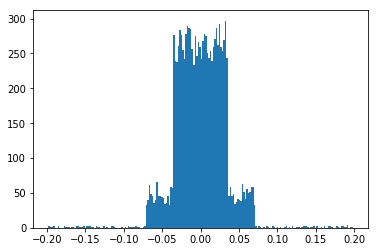

In [33]:
import matplotlib.pyplot as plt

# 초기화 당시의 모델(학습 안된 것) weights이 갖고 있는 값들을 histogram으로 확인
orig_params = []
for param in orig_model.parameters():
  orig_params.append(param.data.cpu().numpy().flatten())
orig_params_flat = np.concatenate(orig_params)
_ = plt.hist(orig_params_flat, bins=200)
plt.show()

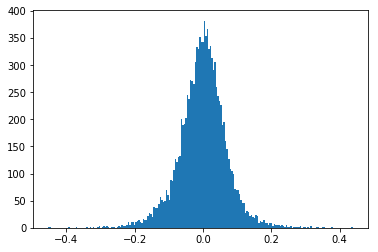

In [34]:
# 학습이 끝난 뒤, weights 들이 갖고 있는 값의 분포를 histogram으로 확인
final_params = []
for param in best_model.parameters():
  final_params.append(param.data.cpu().numpy().flatten())
final_params_flat = np.concatenate(final_params)
_ = plt.hist(final_params_flat, bins=200)
plt.show()